<a href="https://colab.research.google.com/github/sgalrot/eye_gender_classification/blob/main/eye_gender_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Gender Classifier

### Some Colab Setup

Installing kaggle and downloading the dataset

You should download the **kaggle.json** file from your kaggle account and upload it once prompted with "upload file"

In case you are using local machine, just (not tested):

1) `pip install`

2) download dataset using `kaggle datasets download -d pavelbiz/eyes-rtte`

In [1]:
from os.path import exists, expanduser
if not exists(expanduser('~/.kaggle/kaggle.json')):
  !pip install -q kaggle # type: ignore
  from google.colab import files 
  files.upload()
  !mkdir ~/.kaggle # type: ignore
  !cp kaggle.json ~/.kaggle/ # type: ignore
  !chmod 600 ~/.kaggle/kaggle.json # type: ignore

# Downloading the dataset
!kaggle datasets download -d pavelbiz/eyes-rtte
!mkdir dataset
!unzip eyes-rtte.zip -d ./dataset/

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/maleeyes/2430.jpg  
  inflating: ./dataset/maleeyes/2431.jpg  
  inflating: ./dataset/maleeyes/2432.jpg  
  inflating: ./dataset/maleeyes/2433.jpg  
  inflating: ./dataset/maleeyes/2434.jpg  
  inflating: ./dataset/maleeyes/2435.jpg  
  inflating: ./dataset/maleeyes/2436.jpg  
  inflating: ./dataset/maleeyes/2437.jpg  
  inflating: ./dataset/maleeyes/2438.jpg  
  inflating: ./dataset/maleeyes/2439.jpg  
  inflating: ./dataset/maleeyes/244.jpg  
  inflating: ./dataset/maleeyes/2440.jpg  
  inflating: ./dataset/maleeyes/2441.jpg  
  inflating: ./dataset/maleeyes/2442.jpg  
  inflating: ./dataset/maleeyes/2443.jpg  
  inflating: ./dataset/maleeyes/2444.jpg  
  inflating: ./dataset/maleeyes/2445.jpg  
  inflating: ./dataset/maleeyes/2446.jpg  
  inflating: ./dataset/maleeyes/2448.jpg  
  inflating: ./dataset/maleeyes/2449.jpg  
  inflating: ./dataset/maleeyes/245.jpg  
  inflating: ./dataset/maleeyes/2450.jpg  
  inf

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from skimage.transform import resize
from skimage.io import imread


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Loading the Eyes Dataset

We will use again the digits dataset from the last assignment.

In [3]:
from os.path import split
import glob
path = 'dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))

labels = list(map(lambda x:split(split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)

labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,dataset/maleeyes/3189.jpg,maleeyes
1,dataset/femaleeyes/4187.jpg,femaleeyes
2,dataset/femaleeyes/6471.jpg,femaleeyes
3,dataset/maleeyes/5916.jpg,maleeyes
4,dataset/femaleeyes/4344.jpg,femaleeyes


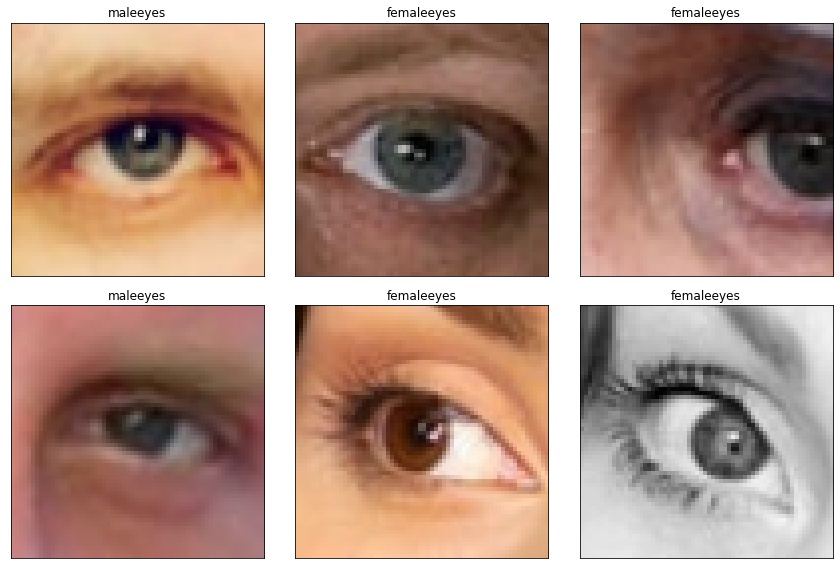

In [4]:
image_resize_shape = (64, 64, 3)
x = np.array([resize(imread(file_path), image_resize_shape, anti_aliasing=True) 
                for file_path in data.File_Path])
y = np.array([1 if label == "femaleeyes" else 0 for label in data.Labels])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i])
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

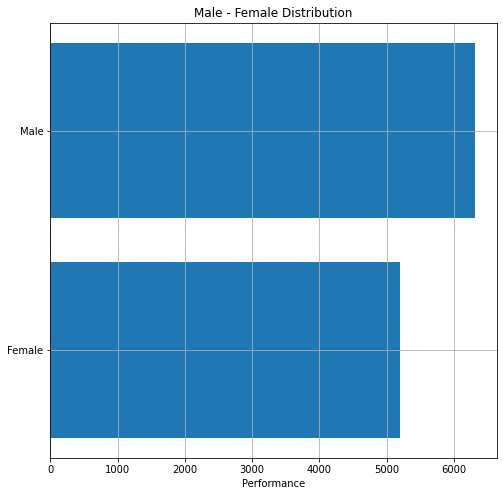

Male-Female Ratio = 1.2154940407535564


In [ ]:
counts = data.Labels.value_counts()
fig, ax = plt.subplots()
hbars = ax.barh([0, 1], counts, align='center')
ax.set_yticks([0, 1])
ax.set_yticklabels(("Male", "Female"))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Male - Female Distribution')
plt.show()
print("Male-Female Ratio = {}".format(counts[0]/counts[1]))

## Train-Validation-Test split

In [ ]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
train_indices = indices[:int(0.6 * n_samples)]
val_indices = indices[int(0.6 * n_samples):int((0.6 + 0.2) * n_samples)]
test_indices = indices[int((0.6 + 0.2) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
x_train = x[train_indices]
y_train = y[train_indices]
x_val = x[val_indices]
y_val = y[val_indices]
x_test = x[test_indices]
y_test = y[test_indices]

## Linear Logistic Regression

We will start by rewriting the linear logistic regression model using PyTorch.

**Reminder**: We are modeling the conditional distribution of the labels as:

The way define and train models in PyTorch is by creating a class (which inherits the class of *torch.nn.Module*) and has two methods:

- **\_\_init\_\_**: Which initialize the models layers with their parameters.
- **forward**: which implements the model's functionality.

We will implement the class using the following objects / functions from PyTorch:

- [**torch.nn.Linear**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear): defines a linear layer with its parameters, $\Theta$. It is defined by the number of **input_features**, the number of **output_features**.
- [**torch.nn.functional.log_softmax**](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.log_softmax) which implements the log-softmax function.

In [ ]:
class LinearLogisticRegression(torch.nn.Module):
     
    def __init__(self, in_features, out_features):   
        super(LinearLogisticRegression, self).__init__()
        
        ## Defining the linear function with it's parameters
        ## =================================================
        self.linear = torch.nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        z = self.linear(x)
        y = torch.nn.functional.log_softmax(z, dim=1)
        
        return y

## Mini-Batch Gradient Decent

In order to run over the dataset using mini batches PyTorch offers the class of [**torch.utils.data.DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which receives a PyTorch dataset and generates a series of batches running over the dataset.

To generate a PyTorch dataset from a tensor of x and a tensor of y we will use the following command:

```python
torch.utils.data.TensorDataset(x, y)
```

We will convert x_train into a float tensor and y_train into a long integer tensor.

In [ ]:
batch_size = 256
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

The following function implement mini-batch gradient descent using:

- The built-in optimization object [**torch.optim.SGD**](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) which performs gradient descent steps on a given set of parameters.
- The built-in loss function [**torch.nn.functional.nll_loss**](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.nll_loss) which calculates the negative log-likelihood of a matrix of log-probabilities, $P$, and a vector of labels, $\boldsymbol{y}$ : $-\frac{1}{N}\sum_iP_{i,y_i}$

  0%|          | 0/10 [00:00<?, ?it/s]

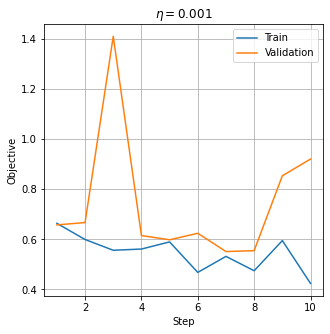

In [ ]:
def train(model, eta, n_epochs, train_loader, x_val, y_val):
    ## Move validation set to the GPU
    x_val = x_val.cuda()
    y_val = y_val.cuda()
    
    ## Initizalie the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)

    ## Prepare lists to store intermediate obejectives
    train_objective_list = [np.inf]
    val_objective_list = [np.inf]
    
    ## Run for n_epochs
    for epoch in tqdm.tqdm(range(n_epochs)):
        ## Run over the batches
        for x, y in train_loader:

            ## Move batch to GPU
            x = x.cuda()
            y = y.cuda()
            
            optimizer.zero_grad()
            ## Forward pass
            py_hat = model(x)
            objective = torch.nn.functional.nll_loss(py_hat, y)
            ## Backward pass
            objective.backward()
            ## Preform the gradient descent step
            optimizer.step()
    
        ## Evaluate the objective on the validation set
        with torch.no_grad(): ## This tell PyTorch not to calculate the gradients to save time
            train_objective_list.append(objective.item())

            py_hat = model(x_val)
            objective = torch.nn.functional.nll_loss(py_hat, y_val)
            val_objective_list.append(objective.item())

    return train_objective_list, val_objective_list

## Test the train function
eta = 0.001
n_epochs = 10
model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.legend();

### Selecting the learning rate

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

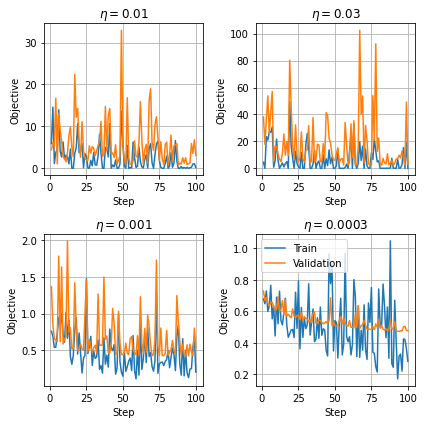

In [ ]:
n_epochs = 100
etas_list = (1e-2, 3e-2, 1e-3, 3e-4)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())

    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1,1].legend()
fig.tight_layout()

Selecting the largest learning rate $\eta$ in which the validation graph does not have large spikes (>0.1).


  0%|          | 0/200 [00:00<?, ?it/s]

(0.0, 0.5)

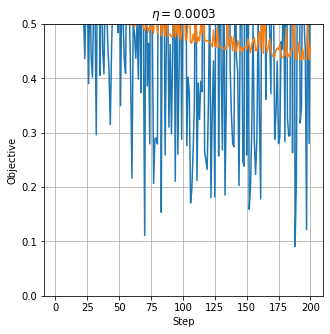

In [ ]:
eta = 0.0003
n_epochs = 200
model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.5)


### Early Stopping

We would like to stop the training when the validation objective reaches its minimum.

199


  0%|          | 0/199 [00:00<?, ?it/s]

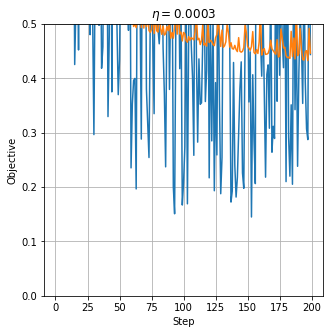

In [ ]:
optimal_number_of_steps = np.argmin(val_objective_list)
print(optimal_number_of_steps)

model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, optimal_number_of_steps, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.5);

### Evaluating the Model on the Test Set

The following code calculates the misclassification rate on the test set.

In order to so we will define a data loader on the test set.

In [ ]:
test_set = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)

## Evaluate the score on the test set
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score = np.sum(test_score_list) / len(test_set)

print(f'The test score is: {test_score:.3}')

The test score is: 0.183


## MLP

Now that we have a training function and we know have some naive model we can try a bit more complex models.

Specifically, we will run one MLP network and one CNN network.

I.e., build a network with of the following layers:

- **fc1**: A fully connected (linear) layer with an input of the in_features and output of 1024 with a ReLU activation.
- **fc2**: A fully connected of 1024x1024 + ReLU.
- **fc3**: A fully connected of 1024xout_features.
- A softmax function

In our case:

- in_features = 64*64*3
- out_features = 2

We will use the function [**torch.nn.functional.relu**](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) to implement the ReLU activation.

  0%|          | 0/50 [00:00<?, ?it/s]

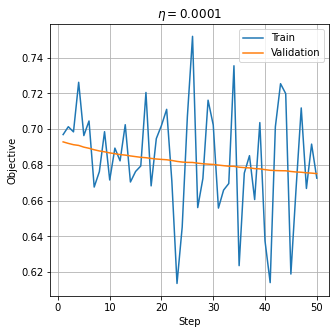

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, in_features, out_features):   
        super(MLP, self).__init__()
        
        ## Defining the fully connected (linear) layers with their parameters
        ## ==================================================================
        self.linear1 = torch.nn.Linear(in_features=in_features, out_features=1024, bias=True)
        self.linear2 = torch.nn.Linear(in_features=1024, out_features=1024, bias=True)
        self.linear3 = torch.nn.Linear(in_features=1024, out_features=out_features, bias=True)
    
    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        z = self.linear1(x)
        z = torch.nn.functional.relu(z)
        z = self.linear2(z)
        z = torch.nn.functional.relu(z)
        z = self.linear3(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        
        return y

## Test the train function
eta = 0.0001
n_epochs = 50
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');
ax.legend()

### Selecting the learning rate

In [ ]:
n_epochs = 350
etas_list = (1e-3, 3e-4)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1].legend()
fig.tight_layout()

  0%|          | 0/350 [00:00<?, ?it/s]

We choose $\eta=1e-5$ and train the model for 400 epochs.

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, 'Objective')

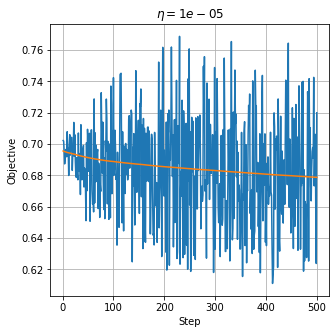

In [ ]:
eta = 1e-4
n_epochs = 500
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')

Text(0, 0.5, 'Objective')

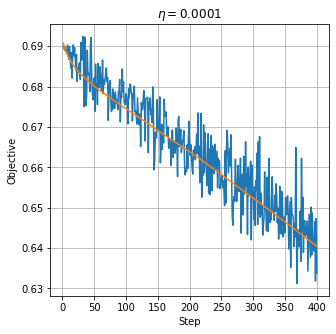

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')

### Early Stopping

We would like to stop the training when the validation objective reaches its minimum.

300


  0%|          | 0/300 [00:00<?, ?it/s]

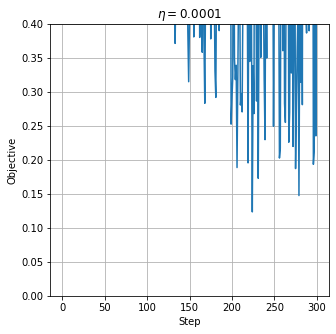

In [ ]:
optimal_number_of_steps = np.argmin(train_objective_list)
print(optimal_number_of_steps)
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, optimal_number_of_steps, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.4);

### Evaluating the Model on the Test Set

In [ ]:
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score = np.sum(test_score_list) / len(test_set)

print(f'The test score is: {test_score:.3}')

The test score is: 0.205


## CNN

We will now also implement a CNN network.

In the code below we define a CNN which is composed of the following layers:

- **conv1**: A convolutional layer with a 3x3 kernel, 1 input channels, 64 output channels, a padding of 1 on each edge + ReLU.
- **conv2**: A convolutional layer with a 3x3 kernel, 64 input, 64 output, padding of 1, **stride of 2** + ReLU.
- **fc3**: A fully connected of (64\*4\*4)x256 + ReLU.
- **fc4**: A fully connected of 256x10.
- A softmax function

  0%|          | 0/30 [00:00<?, ?it/s]

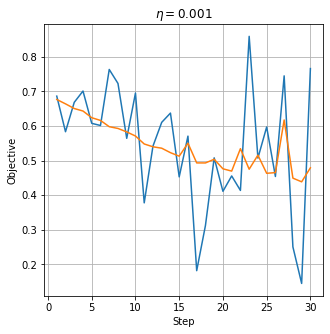

In [ ]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
class CNN(torch.nn.Module):

    def __init__(self, in_features, out_features):   
        super(CNN, self).__init__()
        
        ## Defining the convolutional and fully connected layers with their parameters
        ## ===========================================================================
        self.bn0 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.fc3 = torch.nn.Linear(in_features=64*64*4*4, out_features=256)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=out_features)
    
    def forward(self, x):
        # x = x[:, None, :, :]
        # import pdb; pdb.set_trace()
        x = x.transpose(1,3)
        z = self.bn0(x)
        z = self.conv1(z)
        z = torch.nn.functional.relu(z)
        z = self.conv2(z)
        z = torch.nn.functional.relu(z)
        z = z.view(z.shape[0], -1)
        z = self.fc3(z)
        z = torch.nn.functional.relu(z)
        z = self.fc4(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        
        return y
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

## Test the train function
eta = 0.001
n_epochs = 30
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

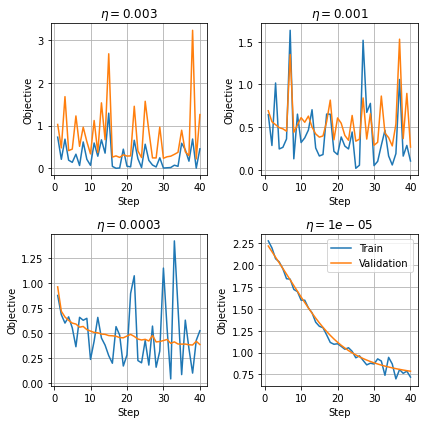

In [ ]:
nn_epochs = 40
etas_list = (3e-3, 1e-3, 3e-4, 1e-5)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=10)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, nn_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1,1].legend()
fig.tight_layout()

✍️ Fill in the following cells to:

1. Use $\eta=0.003$ and fill in the code below to train the model for 1000 epochs.
2. Retrain the model using early stopping.
3. Calculate the misclassification on the test set.

Copy the code for plotting the objectives from the cells above.

  0%|          | 0/200 [00:00<?, ?it/s]

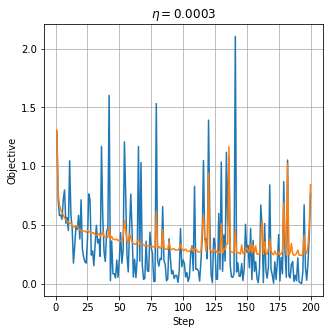

In [ ]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
eta = 0.0003
n_epochs = 200
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=10)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

187


  0%|          | 0/187 [00:00<?, ?it/s]

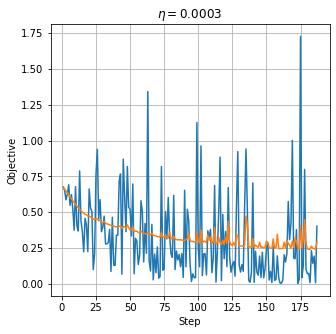

In [ ]:
## %%%%%%%%%%%%%%% Your code here - Begin %%%%%%%%%%%%%%%
optimal_number_of_steps = np.argmin(val_objective_list)
print(optimal_number_of_steps)

eta = 0.0003
n_epochs = optimal_number_of_steps
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');
## %%%%%%%%%%%%%%% Your code here - End %%%%%%%%%%%%%%%%%

In [ ]:
test_set = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score = np.sum(test_score_list) / len(test_set)

print(f'The test score is: {test_score:.3}')

The test score is: 0.128
